<a href="https://colab.research.google.com/github/pierrelarmande/notebooks/blob/main/WITH_ANSWERS_Additional_Hands_On_SW_4_Life_Sciences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the packages

In [ ]:
!pip install rdflib SPARQLWrapper requests pandas geopandas

# Query Dbpedia : What is the impact of pandemic per country ?
See original query here [link](https://egonw.github.io/SARS-CoV-2-Queries/pandemic.html)

In [2]:
import requests

query = """
SELECT ?countryLabel ?maxPopulation ?maxDeath  WITH {
  SELECT DISTINCT ?country (MAX(?numDeaths) AS ?maxDeath) (MAX(?population) AS ?maxPopulation) WHERE {
    ?outbreak p:P31 [ ps:P31 wd:Q3241045 ; pq:P642 wd:Q84263196 ] ;
              wdt:P276 ?country ; wdt:P1120 ?numDeaths .
    ?country wdt:P31 wd:Q3624078 ; wdt:P1082 ?population .
  } GROUP BY ?country
} AS %DATA {
  INCLUDE %DATA
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en,en". }
}
"""

1. execute the query using SPARQLWrapper on (https://query.wikidata.org/sparql) and get the results in a variable

In [3]:
from SPARQLWrapper import SPARQLWrapper, JSON
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setReturnFormat(JSON)
sparql.setQuery(query)
results = sparql.query().convert()

# Print the results
note: results are available as key/value pair in **results["results"]["bindings"]**. Key correspond to select variable name of the SPARQL query

In [ ]:
for result in results["results"]["bindings"]:
    print(f'{result["countryLabel"]["value"]} --> {result["maxDeath"]["value"]}')

# Import the result in a pandas dataframe

In [5]:
import pandas as pd
from collections import OrderedDict

countries = []
for item in results['results']['bindings']:
    countries.append(OrderedDict({
        'country': item['countryLabel']['value'],
        'population': item['maxPopulation']['value'],
        'maxDeath': item['maxDeath']['value'],
        }))



1. Set the country name as index of the dataframe 
2. Set the type of population and maxDeath column as float ( use **astype** function)
3. sort the DF by maxDeath decreasing

In [6]:
df = pd.DataFrame(countries)
df.set_index('country', inplace=True)

In [7]:
df = df.astype({'population': float, 'maxDeath': float })

# Plot the results in a bar chart
1. plot the 30 first results of the dataframe

In [ ]:
df.sort_values(by='maxDeath', inplace=True, ascending=False)
df30 = df.head(30)
df30

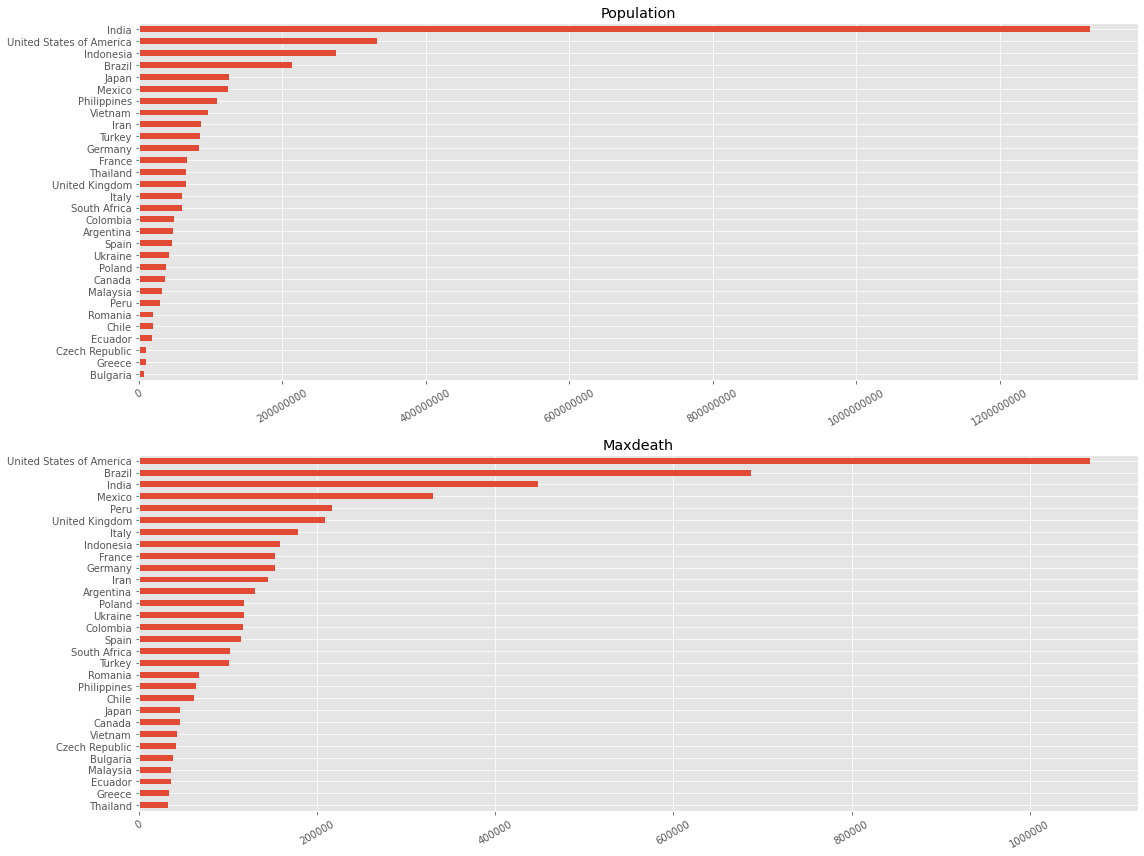

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(16, 12))
for i, label in enumerate(['population', 'maxDeath']):
    plt.subplot(2, 1, i + 1)
    df_plot = df30[label].sort_values().dropna()
    df_plot.plot(kind='barh', color='C0', ax=plt.gca());
    plt.ylabel('')
    plt.xticks(rotation=30)
    plt.title(label.capitalize())
    plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

# Plot the results in a world map

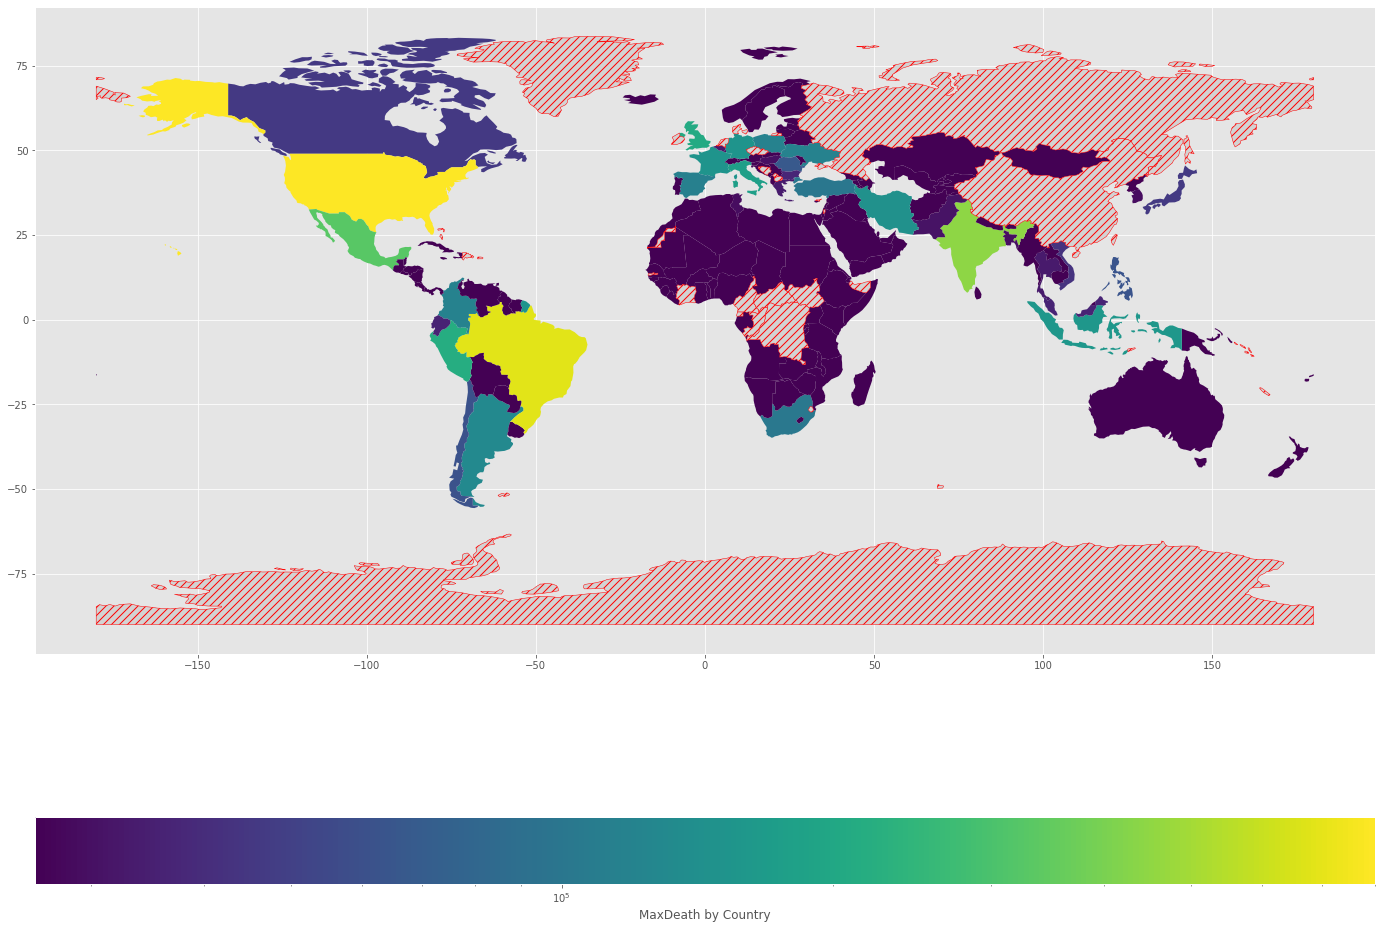

In [13]:
import geopandas
from numpy import log10
import matplotlib.colors as colors

# Read the geopandas dataset
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#print(world.head())
# Merge the two DataFrames together
worldmap = world.merge(df, how="left", left_on=['name'], right_on=['country'])

#worldmap = worldmap.dropna(subset=['maxDeath'])
#worldmap['logval'] = log10(worldmap['maxDeath'])
#print(worldmap.head())
fig, ax = plt.subplots(figsize=(24,20))
##worldmap.plot(column='maxDeath', ax=ax, legend=True)
worldmap.plot(column='maxDeath',
           ax=ax,
           legend=True,
           legend_kwds={'label': "MaxDeath by Country",
                        'orientation': "horizontal"}, 
             norm=colors.LogNorm(vmin=26000, vmax=800000),
              missing_kwds={
              "color": "lightgrey",
              "edgecolor": "red",
              "hatch": "///",
              "label": "Missing values",
                },
            )

Web Sources: <br>
- https://geopandas.org/en/stable/docs/user_guide.html
- 
https://towardsdatascience.com/where-do-mayors-come-from-querying-wikidata-with-python-and-sparql-91f3c0af22e2
- https://egonw.github.io/SARS-CoV-2-Queries
